# Florian Goeman's AI Final Project - Zero Shot
## Loading the CLIP pipeline  
We load the `zero-shot-image-classification` pipeline using the pretrained `openai/clip-vit-base-patch32` model.  
Setting `device=-1` ensures the model runs on CPU — useful when GPU access is limited or unavailable.

In [16]:
from transformers import pipeline

detector = pipeline(
    "zero-shot-image-classification",
    model="openai/clip-vit-base-patch32",
    device=-1   # 👈 THIS forces CPU
)

pytorch_model.bin:  11%|#         | 73.4M/679M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Device set to use cpu


### Loading the dog breed dataset  
We load the custom Stanford Dogs dataset from the Hugging Face Hub. It includes **12,000 training** and **8,580 test images**.

In [ ]:
from datasets import load_dataset

dataset = load_dataset('maurice-fp/stanford-dogs')
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8580
    })
})

We display the first image from the training data found in the dataset to test if it works.

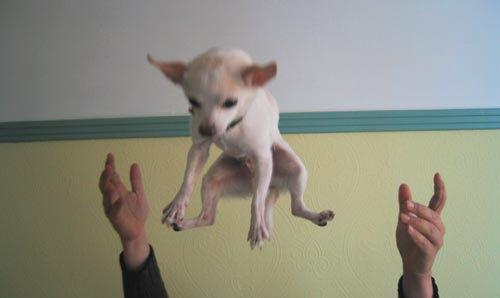

In [ ]:
dataset['train'][0]['image']

### Preparing label data  
We extract the list dog breeds from the dataset metadata and initialize empty lists to store true and predicted labels.

In [ ]:
from PIL import Image
import io
from tqdm import tqdm

from datasets import load_dataset

dataset = load_dataset("maurice-fp/stanford-dogs")

# Get the list of class names from dataset metadata
labels_dogs = dataset['train'].features['label'].names
print(labels_dogs)

# List to store true labels and predicted labels
true_labels = []
predicted_labels = []

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

### Visualizing class distribution  
We count the number of samples per dog breed in the training set and plot the distribution to check for class imbalance.

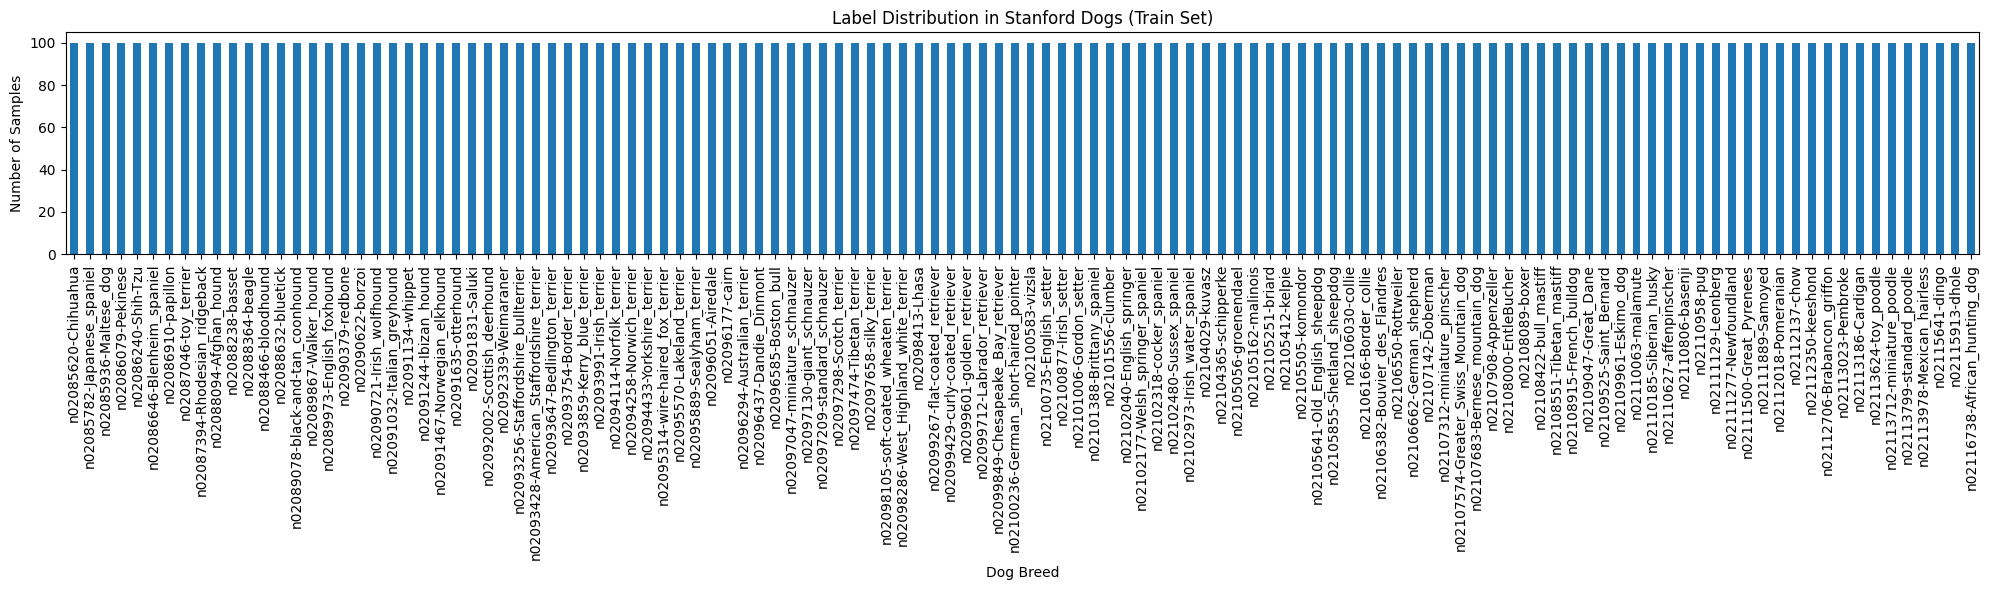

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Count how many samples per label in train split
label_counts = [example["label"] for example in dataset["train"]]
counts = pd.Series(label_counts).value_counts().sort_index()

# Use the label names to match indices
counts.index = labels_dogs

# Plot the distribution
plt.figure(figsize=(20, 6))
counts.plot(kind="bar")
plt.title("Label Distribution in Stanford Dogs (Train Set)")
plt.xlabel("Dog Breed")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Running zero-shot predictions  
Each training image is passed through the CLIP detector using the full list of dog breed labels.  
The top prediction is saved alongside the true label for later evaluation.

In [ ]:

for i in tqdm(range(len(dataset['train']))):
    
    image = dataset['train'][i]['image']
    
    # Run the detector on the image with the provided labels
    results = detector(image, candidate_labels=labels_dogs)
    # Sort the results by score in descending order
    sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)
    
    # Get the top predicted label
    predicted_label = sorted_results[0]['label']
    
    # Append the true and predicted labels to the respective lists
    true_labels.append(labels_dogs[dataset['train'][i]['label']])
    predicted_labels.append(predicted_label)


100%|██████████| 12000/12000 [5:36:46<00:00,  1.68s/it] 


### Evaluating zero-shot performance  
We compute accuracy, precision, and recall for the zero-shot predictions.  
All metrics are around **48%**, reflecting the difficulty of the task without fine-tuning.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average='weighted', labels=labels_dogs)
recall = recall_score(true_labels, predicted_labels, average='weighted', labels=labels_dogs)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.4849
Precision: 0.4800
Recall: 0.4849


c:\Users\Fiona Müller\Desktop\ZHAW\AI_Training_Computer_Vision\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Dog Breed Classifier – Gradio Example  
We start by loading a fine-tuned ViT model trained for bird classification.  
In parallel, we load a zero-shot CLIP model and provide it with the same set of bird species as candidate labels.  
This allows us to build a Gradio interface for side-by-side comparison.

In [24]:
import gradio as gr
from transformers import pipeline

# Load models
vit_classifier = pipeline("image-classification", model="Flogoro/vit-base-maurice-fp-stanford-dogs")
clip_detector = pipeline(model="openai/clip-vit-large-patch14", task="zero-shot-image-classification")

labels_dogs = dataset['train'].features['label'].names

def classify_dog(image):
    vit_results = vit_classifier(image)
    
    # Map numeric string labels to actual dog names using labels_dogs
    vit_output = {
        labels_dogs[int(result['label'])]: result['score']
        for result in vit_results
    }
    
    clip_results = clip_detector(image, candidate_labels=labels_dogs)
    clip_output = {
        str(result['label']): result['score']
        for result in clip_results
    }

    return {
        "ViT Classification": vit_output,
        "CLIP Zero-Shot Classification": clip_output
    }


example_images = [
    ["example_images/dog1.png"],
    ["example_images/dog2.png"],
    ["example_images/dog3.png"],
    ["example_images/dog4.png"]
]

iface = gr.Interface(
    fn=classify_dog,
    inputs=gr.Image(type="filepath"),
    outputs=gr.JSON(),
    title="Dog Classification Comparison",
    description="Upload an image of a dog, and compare results from a trained ViT model and a zero-shot CLIP model.",
    examples=example_images
)

iface.launch()

Device set to use cpu
Device set to use cpu


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
